# 0 - **Init**

## Library

In [ ]:
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# Data Augmentaiton-------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#-------------------------------

# Model Training----------------
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger
#from keras import backend as keras
from tensorflow.keras import backend as k
from keras.initializers import glorot_uniform
#-------------------------------

#Load-Save Data-----------------
import pickle
#-------------------------------

#Load-Save weights--------------
from keras.callbacks import ModelCheckpoint, CSVLogger
#-------------------------------


## Google Drive Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# 1 - **Dataset Elaboration**

## 1.1 - Load Data

In [ ]:
params = {'x':224,                                
          'y':160,                                
          'batch_size': 8,                        
          'n_channels_mask': 1,                            
          'n_channels': 1,                        
          'shuffle': True,              
          'learningRate': 0.0001,                      
          'momentum': 0.98,                        
          'nEpoches': 20,                        
          }

### Load without backup

In [ ]:
dataset  = "/content/gdrive/MyDrive/CVDL_IA/Dataset" 
type_ds  = ['Images','Masks'] # sudivisione cartelle

# get path Img and Mask
path_img  = os.path.join(dataset, type_ds[0])
path_msk  = os.path.join(dataset, type_ds[1])

# get length imgs and proof that is equal with masks
length_imgs  = len(os.listdir(os.path.join(dataset,type_ds[0] + "/"))) 
length_masks = len(os.listdir(os.path.join(dataset,type_ds[1] + "/")))

params['length_data'] = length_imgs, 

dim = (params['x'],params['y'])

N = length_imgs
X = np.empty((N, params['y'],params['x'], params['n_channels']))
y = np.empty((N, params['y'],params['x'], params['n_channels_mask']))
imgs_list_path = os.listdir(path_img)[:N]

i = 0
for im in sorted(imgs_list_path):
        image = cv2.imread(os.path.join(path_img,im),0)
        image = cv2.resize(image,dim)

        mea = np.mean(image)
        ss = np.std(image)
        image = (image - mea)/ss

        mask = cv2.imread(os.path.join(path_msk,im),0)
        mask = cv2.resize(mask,dim)
        mask = mask / 255

        X[i,:,:,0] = image
        y[i,:,:,0] = mask
        i += 1 

In [ ]:
# Save a dictionary into a pickle file.
pickle.dump(X, open( "imgs.p", "wb" ) )
pickle.dump(y, open( "masks.p", "wb" ) )

### Load backup with Pickle

In [ ]:
# Load a dictionary into a pickle file.
X = pickle.load( open( "/content/gdrive/MyDrive/CVDL_IA/Dataset/imgs.p", "rb" ) )
y = pickle.load( open( "/content/gdrive/MyDrive/CVDL_IA/Dataset/masks.p", "rb" ) )

### Show Data

In [ ]:
print(X.shape)
print(y.shape)

(246, 160, 224, 1)
(246, 160, 224, 1)


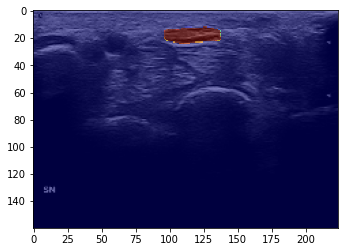

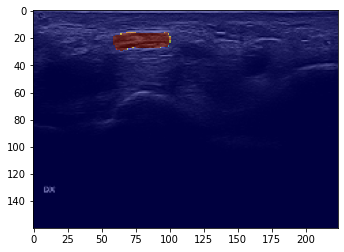

In [ ]:
plt.figure(1)
plt.imshow(X[2,:,:,0], cmap='gray')
plt.imshow(y[2,:,:,0], 'jet', interpolation='none', alpha=0.5)

plt.figure(2)
plt.imshow(X[0,:,:,0],cmap='gray')
plt.imshow(y[0,:,:,0],'jet', interpolation='none', alpha=0.5)

## 1.2 - Split the Dataset

In [ ]:
from sklearn.model_selection import train_test_split


# Split in train / test 
X_train_old, X_test, y_train_old, y_test = train_test_split(X,
                                                            y, 
                                                            test_size = 0.30,
                                                            random_state = 42)

# Split in train / valid
X_train, X_val, y_train, y_val  = train_test_split(X_train_old,
                                                   y_train_old,
                                                   test_size = 0.10,
                                                   random_state = 42)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(154, 160, 224, 1)
(18, 160, 224, 1)
(74, 160, 224, 1)
(154, 160, 224, 1)
(18, 160, 224, 1)
(74, 160, 224, 1)


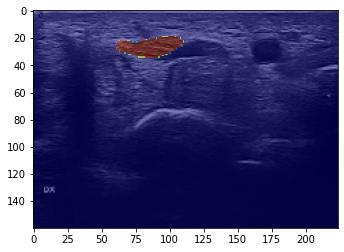

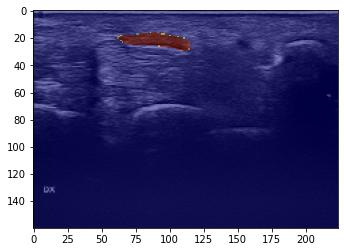

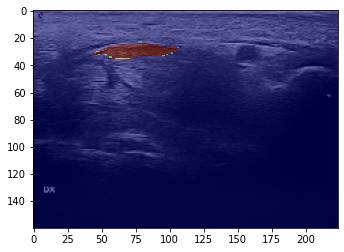

In [ ]:
plt.figure(1)
plt.imshow(X_train[0,:,:,0],cmap='gray')
plt.imshow(y_train[0,:,:,0],'jet', interpolation='none', alpha=0.5)

plt.figure(2)
plt.imshow(X_val[0,:,:,0],cmap='gray')
plt.imshow(y_val[0,:,:,0],'jet', interpolation='none', alpha=0.5)
plt.figure(3)

plt.imshow(X_test[0,:,:,0],cmap='gray')
plt.imshow(y_test[0,:,:,0],'jet', interpolation='none', alpha=0.5)

## 1.3 - Data Augmentation

In [ ]:
seed = 42

#####################################TRAIN######################################
train_img_datagen  = ImageDataGenerator(rotation_range = 25, fill_mode='constant')
train_msk_datagen  = ImageDataGenerator(rotation_range = 25, fill_mode='constant')

train_img_datagen.fit(X_train, augment=True, seed=seed)
train_msk_datagen.fit(y_train, augment=True, seed=seed)

train_img_generator = train_img_datagen.flow(X_train, batch_size = params['batch_size'], shuffle = True, seed=seed)
train_msk_generator = train_msk_datagen.flow(y_train, batch_size = params['batch_size'], shuffle = True, seed=seed)

train_generator = zip(train_img_generator, train_msk_generator)

###################################VALIDATION###################################
vali_img_datagen = ImageDataGenerator()
vali_msk_datagen = ImageDataGenerator()

vali_img_datagen.fit(X_val, seed=seed)
vali_msk_datagen.fit(y_val, seed=seed)

val_img_generator = vali_img_datagen.flow(X_val, batch_size = params['batch_size'], seed=seed)
val_msk_generator = vali_msk_datagen.flow(y_val, batch_size = params['batch_size'], seed=seed)

val_generator = zip(val_img_generator, val_msk_generator)

In [ ]:
# examples of random data agumentation
batchx, batchy = next(train_generator)

for i in range(batchx.shape[0]):
    fig, ax = plt.subplots(1, 3) 
    ax[0].set_title('image')  
    ax[0].imshow(batchx[i][:,:,0], cmap='gray')
    ax[1].set_title('label') 
    ax[1].imshow(batchy[i][:,:,0], cmap='gray')
    ax[2].set_title('image+label')
    ax[2].imshow(batchx[i][:,:,0], cmap='gray')
    ax[2].imshow(batchy[i][:,:,0], 'jet', interpolation='none', alpha=0.5)

#2 - **Define Model**

In [ ]:
initializer = glorot_uniform()
def unet(input_size = (160,224,1)):
    inputs = Input(input_size) 
    #---------------------------ENCODING----------------------------------------
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    #---------------------------------------------------------------------------

    #---------------------------BOTTLENECK--------------------------------------
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv5)
    drop5 = Dropout(0.5)(conv5)
    #---------------------------------------------------------------------------

    #---------------------------DECODING--------------------------------------
    up6    = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge6)
    conv6  = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv6)
    up7    = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge7)
    conv7  = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv7)

    up8    = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge8)
    conv8  = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv8)


    up9    = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9  = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge9)
    conv9  = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv9)
    conv9  = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #---------------------------------------------------------------------------

    model = Model(inputs,conv10)

    #model.summary()

    return model

# 3 - **Model Training**

In [ ]:
params["length_training"]   = len(X_train)
params['length_validation'] = len(X_val)
params["batch_size"] = 6

model = unet()

##Saving last weights and TRAIN


In [ ]:
model.compile(optimizer = Adam(learning_rate = params["learningRate"]),
                               loss = "binary_crossentropy", 
                               metrics = ['accuracy'])
steps_per_epoch = np.ceil(params["length_training"]/params["batch_size"])

history = model.fit(train_generator, 
                    steps_per_epoch = steps_per_epoch, 
                    epochs = params["nEpoches"],
                    validation_data = val_generator, 
                    verbose = 1, 
                    validation_steps=(params['length_validation']/params["batch_size"]))

model_json_tuned = model.to_json()

with open("./model.json", "w") as json_file:
    json_file.write("model")
    
model.save_weights("./weights.h5") #this saves the weights of the last epoch, only!
print("Saved model and weights in the directory")


Epoch 1/20


##Saving best weights and TRAIN



In [ ]:
# define where to save weights and run the training
root = '/content/gdrive/MyDrive/CVDL_IA/Dataset/Save_weights'

filepath = root + '/results/unet/Model{epoch:03d}-{loss:2f}.hdf5'

print(filepath)

checkPoint = ModelCheckpoint(filepath, 
                             monitor = 'val_loss', 
                             verbose = 1, 
                             save_best_only = True,
                             mode = 'min')
callbacks_list = checkPoint  

# for fine tuning purposes
#model.load_weights(root + '/results/Unetprova/Model008-0.161614.hdf5')
#model.load_weights("/content/gdrive/My Drive/CVDL/Segmentation/weights2.h5")

model.compile(optimizer = Adam(learning_rate = params["learningRate"]), 
                               loss = "binary_crossentropy", 
                               metrics = ['accuracy'])
steps_per_epoch = np.ceil(params["length_training"]/params["batch_size"])

csv_logger = CSVLogger(root + '/results/unet.csv', append = True, separator = ';')

history = model.fit(train_generator, 
                    steps_per_epoch = steps_per_epoch, 
                    epochs = params["nEpoches"],
                    validation_data = val_generator, 
                    verbose = 1, 
                    validation_steps = (params['length_validation']/params["batch_size"]), 
                    callbacks = [callbacks_list, csv_logger])

/content/gdrive/MyDrive/CVDL_IA/Dataset/Save_weights/results/unet/Model{epoch:03d}-{loss:2f}.hdf5
Epoch 1/20
26/26 [==============================] - 65s 519ms/step - loss: 0.4496 - accuracy: 0.9105 - val_loss: 0.0597 - val_accuracy: 0.9903

Epoch 00001: val_loss improved from inf to 0.05974, saving model to /content/gdrive/MyDrive/CVDL_IA/Dataset/Save_weights/results/unet/Model001-0.272107.hdf5
Epoch 2/20
26/26 [==============================] - 9s 335ms/step - loss: 0.0515 - accuracy: 0.9883 - val_loss: 0.0396 - val_accuracy: 0.9897

Epoch 00002: val_loss improved from 0.05974 to 0.03955, saving model to /content/gdrive/MyDrive/CVDL_IA/Dataset/Save_weights/results/unet/Model002-0.046428.hdf5
Epoch 3/20
26/26 [==============================] - 9s 338ms/step - loss: 0.0360 - accuracy: 0.9878 - val_loss: 0.0360 - val_accuracy: 0.9902

Epoch 00003: val_loss improved from 0.03955 to 0.03604, saving model to /content/gdrive/MyDrive/CVDL_IA/Dataset/Save_weights/results/unet/Model003-0.03460

Clean the folder and keeping only the best model

In [ ]:
file_path_best = "/content/gdrive/MyDrive/CVDL_IA/Dataset/Save_weights/results/unet/Model017-0.013874.hdf5"

if os.path.isfile(file_path_best):
    #Verifies CSV file was created, then deletes unneeded files.
    for CleanUp in glob.glob('/content/gdrive/MyDrive/CVDL_IA/Dataset/Save_weights/results/unet/*.*'):
        print(CleanUp)
        if not CleanUp.endswith('Model017-0.013874.hdf5'):    
            os.remove(CleanUp)

/content/gdrive/MyDrive/CVDL_IA/Dataset/Save_weights/results/unet/Model011-0.017142.hdf5
/content/gdrive/MyDrive/CVDL_IA/Dataset/Save_weights/results/unet/Model014-0.015672.hdf5
/content/gdrive/MyDrive/CVDL_IA/Dataset/Save_weights/results/unet/Model017-0.013874.hdf5


## Training curves

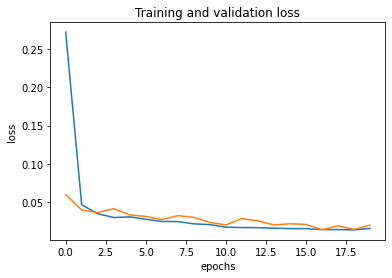

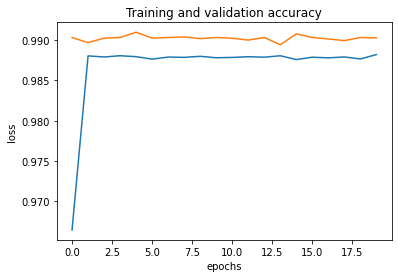

In [ ]:
epochs = params["nEpoches"]

plt.figure()
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")

plt.figure()
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")

# 4 - **Model prediction**


In [ ]:
#model.load_weights("./weights.h5")
model.load_weights(file_path_best)

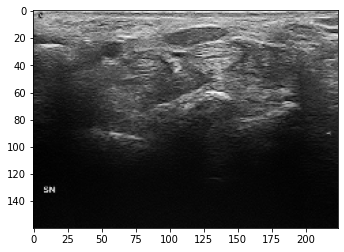

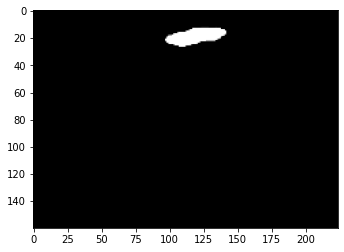

In [ ]:
plt.figure()
plt.imshow(X_test[1,:,:,0], cmap='gray')

plt.figure()
plt.imshow(y_test[1,:,:,0], cmap='gray')

In [ ]:
import cv2
import copy
from keras.preprocessing.image import img_to_array

# immagine di test per valutare la prediction del modello di segmentazione
test_image = X_test[0,:,:,0]
test_mask = y_test[0,:,:,0]

test_image = cv2.resize(test_image,(params["x"],params["y"]))
test_mask = cv2.resize(test_mask,(params["x"],params["y"]))

mean_ = np.mean(test_image)
test_image = test_image - mean_
std = np.std(test_image)
test_image = test_image/std

test_mask = test_mask

test_image = img_to_array(test_image)
test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
#model.predict_classes(X_test)

# prediction
prediction = model.predict(test_image)
# copia per ridefinire la segmentazione ar di intensità dei valori
pred = copy.copy(prediction[0,:,:,0])

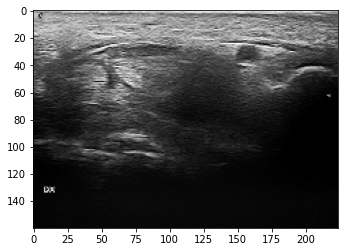

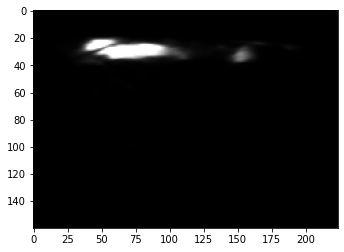

In [ ]:
plt.figure()
plt.imshow(test_image[0,:,:,0], cmap='gray')

plt.figure()
plt.imshow(prediction[0,:,:,0], cmap='gray')

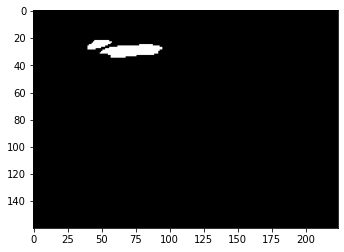

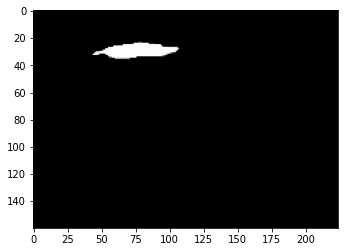

In [ ]:
pred = copy.copy(prediction[0,:,:,0])

pred[pred >= 0.45] = 1
pred[pred < 0.45] = 0

plt.figure()
plt.imshow(pred, cmap='gray')

plt.figure()
plt.imshow(test_mask, cmap='gray')

In [ ]:
from sklearn.metrics import accuracy_score
test_mask = test_mask/255

a = test_mask.flatten()
b = pred.flatten()
a = a.astype(int)
b = b.astype(int)

accuracy = accuracy_score(a, b)
print("testing accuracy dx", accuracy)

testing accuracy dx 0.9889787946428571


## Dice Accurancy

In [ ]:
from tensorflow.keras import backend as K 

def dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    # Test usando Keras.sum() ...
    #dice_numerator = K.sum(2 * im1 * im2, axis=(0, 1, 2)) + empty_score
    #dice_denominator = K.sum(im1, axis= axis) + K.sum(im2, axis =(0, 1, 2)) + empty_score
    #dice_coefficient = dice_numerator / dice_denominator 

    return 2. * intersection.sum() / im_sum

In [ ]:
print('dice_coeff: ', dice(test_mask, pred))

dice_coeff:  0.7025813692480359
